# Tool Calling Agent

- Author: [Kenny Jung](https://www.linkedin.com/in/kwang-yong-jung)
- Design:
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/15-Agent/03-Agent.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/15-Agent/03-Agent.ipynb)


## Overview

Tool calling allows models to detect when one or more **tools** need to be **called and what inputs should be passed** to those tools.
 
In API calls, you can describe tools and intelligently choose to have the model output structured objects like JSON that contain arguments for calling these tools.
 
The goal of the tools API is to return valid and useful **tool calls** more reliably than what could be accomplished using plain text completion or chat APIs.
 
By combining this structured output with the ability to bind multiple tools to a tool-calling chat model and letting the model choose which tools to call, you can create agents that iteratively call tools and receive results until a query is resolved.
 
This is a more **generalized version** of the OpenAI tools agent that was designed specifically for OpenAI's particular tool-calling style.
 
This agent uses LangChain's ToolCall interface to support a wider range of provider implementations beyond OpenAI, including `Anthropic` , `Google Gemini` , and `Mistral` .


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Creating Tools](#creating-tools)
- [Creating Agent Prompt](#creating-agent-prompt)
- [Creating Agent](#creating-agent)
- [AgentExecutor](#agentexecutor)
- [Checking step-by-step results using Stream output](#checking-step-by-step-results-using-stream-output)
- [Customizing intermediate steps output using user-defined functions](#customizing-intermediate-steps-output-using-user-defined-functions)
- [Communicating Agent with previous conversation history](#communicating-agent-with-previous-conversation-history)

### References

- [LangChain Python API Reference > langchain: 0.3.14 > agents > create_tool_calling_agent](https://python.langchain.com/api_reference/langchain/agents/langchain.agents.tool_calling_agent.base.create_tool_calling_agent.html#create-tool-calling-agent)
- [LangChain Python API Reference > langchain: 0.3.14 > core > runnables > langchain_core.runnables.history > RunnableWithMessageHistory](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html)

![](./assets/15-agent-agent-concept.png)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langchain_community",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "ToolCallingAgent",
    }
)

Environment variables have been set successfully.


You can alternatively set `OPENAI_API_KEY` in `.env` file and load it.

[Note] This is not necessary if you've already set `OPENAI_API_KEY` in previous steps.

In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Creating Tools

- Creating tools for searching news and executing python code
- `@tool` decorator is used to create a tool
- `TavilySearchResults` is a tool for searching news
- `PythonREPL` is a tool for executing python code


In [5]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_community.tools import TavilySearchResults
from langchain_experimental.utilities import PythonREPL


# Creating tool for searching news
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search news by input keyword using Tavily Search API"""
    news_tool = TavilySearchResults(
        max_results=3,
        include_answer=True,
        include_raw_content=True,
        include_images=True,
        # search_depth="advanced",
        # include_domains = [],
        # exclude_domains = []
    )
    return news_tool.invoke(query, k=3)


# Creating tool for executing python code
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this tool to execute Python code. If you want to see the output of a value,
    you should print it using print(...). This output is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result


print(f"Tool name: {search_news.name}")
print(f"Tool description: {search_news.description}")
print(f"Tool name: {python_repl_tool.name}")
print(f"Tool description: {python_repl_tool.description}")

Tool name: search_news
Tool description: Search news by input keyword using Tavily Search API
Tool name: python_repl_tool
Tool description: Use this tool to execute Python code. If you want to see the output of a value,
    you should print it using print(...). This output is visible to the user.


In [6]:
# Creating tools
tools = [search_news, python_repl_tool]

## Creating Agent Prompt

- `chat_history` : variable for storing previous conversation (if multi-turn is not supported, it can be omitted.)
- `agent_scratchpad` : variable for storing temporary variables
- `input` : user's input

In [7]:
from langchain_core.prompts import ChatPromptTemplate

# Creating prompt
# Prompt is a text that describes the task the model should perform. (input the name and role of the tool)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

## Creating Agent

In [8]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# Creating LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Creating Agent
agent = create_tool_calling_agent(llm, tools, prompt)

## AgentExecutor

- AgentExecutor is a class for running an agent that uses tools.

**Key properties**
- `agent` : agent that creates plans and decides actions at each step of the execution loop
- `tools` : list of valid tools that the agent can use
- `return_intermediate_steps` : whether to return the intermediate steps of the agent with the final output
- `max_iterations` : maximum number of steps before terminating the execution loop
- `max_execution_time` : maximum time the execution loop can take
- `early_stopping_method` : method to use when the agent does not return `AgentFinish` . ("force" or "generate")
  - `"force"` : returns a string indicating that the execution loop was stopped due to time or iteration limit.
  - `"generate"` : calls the agent's LLM chain once to generate the final answer based on the previous steps.
- `handle_parsing_errors` : Method of handling parsing errors. (True, False, or error handling function)
- `trim_intermediate_steps` : Method of trimming intermediate steps. (-1 trim not, or trimming function)

**Key methods**
1. `invoke` : Run the agent
2. `stream` : Stream the steps needed to reach the final output

**Key features**
1. **Tool validation** : Check if the tool is compatible with the agent
2. **Execution control** : Set maximum number of iterations and execution time limit
3. **Error handling** : Various processing options for output parsing errors
4. **Intermediate step management** : Trimming intermediate steps and returning options
5. **Asynchronous support** : Asynchronous execution and streaming support

**Optimization tips**
- Set `max_iterations` and `max_execution_time` appropriately to manage execution time
- Use `trim_intermediate_steps` to optimize memory usage
- For complex tasks, use the `stream` method to monitor step-by-step results

In [9]:
from langchain.agents import AgentExecutor

# Create AgentExecutor
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
)

# Run AgentExecutor
result = agent_executor.invoke({"input": "Search news about AI Agent in 2025."})

print("Agent execution result:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': 'AI Agent 2025'}`


[{'url': 'https://www.analyticsvidhya.com/blog/2024/12/ai-agent-trends/', 'content': 'In a similar study, Deloitte forecasts that 25% of enterprises using GenAI will deploy AI Agents by 2025, growing to 50% by 2027. Meanwhile, Gartner predicts that by 2028, at least 15% of day-to-day work decisions will be made autonomously through agentic AI. It also states that by then, 33% of enterprise software applications will also include'}, {'url': 'https://www.techtarget.com/searchEnterpriseAI/feature/Next-year-will-be-the-year-of-AI-agents', 'content': 'Next year will be the year of AI agents | TechTarget This will make the AI agent more accurate in completing its task, Greene said. Other than the rise of single-task AI agents, 2025 may also be the year of building the infrastructure for AI agents, said Olivier Blanchard, an analyst with Futurum Group. "2025 isn\'t going to be the year when we

## Checking step-by-step results using Stream output

We will use the `stream()` method of AgentExecutor to stream the intermediate steps of the agent.

The output of `stream()` alternates between (Action, Observation) pairs, and finally ends with the agent's answer if the goal is achieved.

It will look like the following.

1. Action output
2. Observation output
3. Action output
4. Observation output

... (Continue until the goal is achieved) ...

Then, the agent will output the final answer if the goal is achieved.

The content of this output is summarized as follows.

| Output | Content |
|--------|----------|
| Action | `actions`: AgentAction or its subclass<br>`messages`: Chat messages corresponding to the action call |
| Observation | `steps`: Record of the agent's work including the current action and its observation<br>`messages`: Chat messages including the function call result (i.e., observation) |
| Final Answer | `output`: AgentFinish<br>`messages`: Chat messages including the final output |
```

In [10]:
from langchain.agents import AgentExecutor

# Create AgentExecutor
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True,
)

In [11]:
# Run in streaming mode
result = agent_executor.stream({"input": "Search news about AI Agent in 2025."})

for step in result:
    # Print intermediate steps
    print(step)
    print("===" * 20)

{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI Agent 2025'}, log="\nInvoking: `search_news` with `{'query': 'AI Agent 2025'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_xxsGXV6JZgYb7JAb0JU9EQ7o', 'function': {'arguments': '{"query":"AI Agent 2025"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-fc21b730-a5ac-4f0a-b009-585acca6519c', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI Agent 2025'}, 'id': 'call_xxsGXV6JZgYb7JAb0JU9EQ7o', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"AI Agent 2025"}', 'id': 'call_xxsGXV6JZgYb7JAb0JU9EQ7o', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_xxsGXV6JZgYb7JAb0JU9EQ7o')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id'

## Customizing intermediate steps output using user-defined functions

Define the following 3 functions to customize the intermediate steps output.

- `tool_callback`: Function to handle tool call output
- `observation_callback`: Function to handle observation (Observation) output
- `result_callback`: Function to handle final answer output

The following is a callback function used to output the intermediate steps of the Agent in a clean manner.

This callback function can be useful when outputting intermediate steps to users in Streamlit.

In [12]:
from typing import Dict, Any


# Create AgentStreamParser class
class AgentStreamParser:
    def __init__(self):
        pass

    def tool_callback(self, tool: Dict[str, Any]) -> None:
        print("\n=== Tool Called ===")
        print(f"Tool: {tool.get('tool')}")
        print(f"Input: {tool.get('tool_input')}")
        print("==================\n")

    def observation_callback(self, step: Dict[str, Any]) -> None:
        print("\n=== Observation ===")
        observation_data = step["steps"][0].observation
        print(f"Observation: {observation_data}")
        print("===================\n")

    def result_callback(self, result: str) -> None:
        print("\n=== Final Answer ===")
        print(result)
        print("====================\n")

    def process_agent_steps(self, step: Dict[str, Any]) -> None:
        if "actions" in step:
            for action in step["actions"]:
                self.tool_callback(
                    {"tool": action.tool, "tool_input": action.tool_input}
                )
        elif "output" in step:
            self.result_callback(step["output"])
        else:
            self.observation_callback(step)


# Create AgentStreamParser instance
agent_stream_parser = AgentStreamParser()

Check the response process of Agent in streaming mode.

Python REPL can execute arbitrary code. Use with caution.


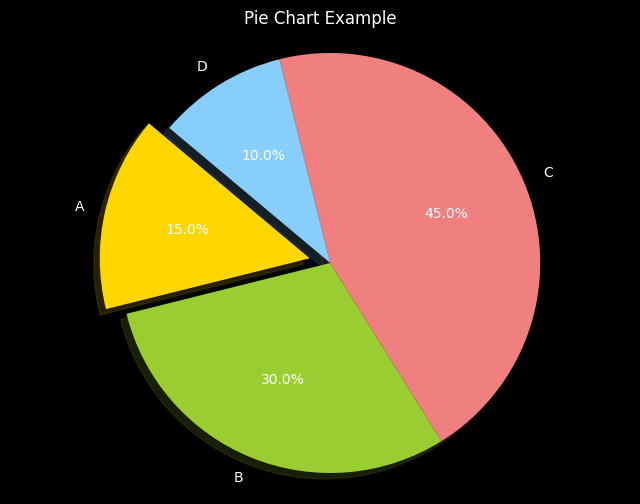


=== Tool Called ===
Tool: python_repl_tool
Input: {'code': "import matplotlib.pyplot as plt\n\n# Data to plot\nlabels = ['A', 'B', 'C', 'D']\nsizes = [15, 30, 45, 10]\ncolors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']\nexplode = (0.1, 0, 0, 0)  # explode 1st slice\n\n# Plot\nplt.figure(figsize=(8, 6))\nplt.pie(sizes, explode=explode, labels=labels, colors=colors,\n        autopct='%1.1f%%', shadow=True, startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Pie Chart Example')\nplt.show()"}


=== Observation ===
Observation: 


=== Final Answer ===
The pie chart has been generated successfully. However, I cannot display the chart directly here. You can run the provided code in your local Python environment to see the pie chart. Here’s the code again for your convenience:

```python
import matplotlib.pyplot as plt

# Data to plot
labels = ['A', 'B', 'C', 'D']
sizes = [15, 30, 45, 10]
colors = ['gold', 'yellowgreen', 'lig

In [13]:
# Run in streaming mode
result = agent_executor.stream({"input": "Generate a pie chart using matplotlib."})
# result = agent_executor.stream({"input": "Search news about AI Agent in 2025."})


for step in result:
    agent_stream_parser.process_agent_steps(step)

In [14]:
# Run in streaming mode
result = agent_executor.stream({"input": "Search news about AI Agent in 2025."})


for step in result:
    agent_stream_parser.process_agent_steps(step)


=== Tool Called ===
Tool: search_news
Input: {'query': 'AI Agent 2025'}


=== Observation ===
Observation: [{'url': 'https://www.analyticsvidhya.com/blog/2024/12/ai-agent-trends/', 'content': 'In a similar study, Deloitte forecasts that 25% of enterprises using GenAI will deploy AI Agents by 2025, growing to 50% by 2027. Meanwhile, Gartner predicts that by 2028, at least 15% of day-to-day work decisions will be made autonomously through agentic AI. It also states that by then, 33% of enterprise software applications will also include'}, {'url': 'https://www.techtarget.com/searchEnterpriseAI/feature/Next-year-will-be-the-year-of-AI-agents', 'content': 'Next year will be the year of AI agents | TechTarget This will make the AI agent more accurate in completing its task, Greene said. Other than the rise of single-task AI agents, 2025 may also be the year of building the infrastructure for AI agents, said Olivier Blanchard, an analyst with Futurum Group. "2025 isn\'t going to be the year 

Modify the callback function to use it.

In [15]:
from typing import Dict, Any, Callable


# 1. Define AgentCallbacks class
class AgentCallbacks:
    def __init__(
        self,
        tool_callback: Callable,
        observation_callback: Callable,
        result_callback: Callable,
    ):
        self.tool_callback = tool_callback
        self.observation_callback = observation_callback
        self.result_callback = result_callback


# 2. Define AgentStreamParser class
class AgentStreamParser:
    def __init__(self, callbacks: AgentCallbacks):
        self.callbacks = callbacks

    def process_agent_steps(self, step: Dict[str, Any]) -> None:
        if "actions" in step:
            for action in step["actions"]:
                self.callbacks.tool_callback(
                    {"tool": action.tool, "tool_input": action.tool_input}
                )
        elif "output" in step:
            self.callbacks.result_callback(step["output"])
        else:
            self.callbacks.observation_callback(step)


# 3. Define callback functions
def tool_callback(tool) -> None:
    print("<<<<<<< Tool Called >>>>>>")
    print(f"Tool: {tool.get('tool')}")
    print(f"Input: {tool.get('tool_input')}")
    print("<<<<<<< Tool Called >>>>>>")


def observation_callback(step) -> None:
    print("<<<<<<< Observation >>>>>>")
    observation_data = step["steps"][0].observation
    print(f"Observation: {observation_data}")
    print("<<<<<<< Observation >>>>>>")


def result_callback(result: str) -> None:
    print("<<<<<<< Final Answer >>>>>>")
    print(result)
    print("<<<<<<< Final Answer >>>>>>")


# 4. Example usage
# Wrap callback functions into AgentCallbacks instance
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# Create AgentStreamParser instance
agent_stream_parser = AgentStreamParser(agent_callbacks)

Check the output content. You can see that the output value of the intermediate content has been changed to the output value of the callback function I modified.

In [16]:
# Request streaming output for the query
result = agent_executor.stream({"input": "Search news about AI Agent in 2025."})

for step in result:
    # Output intermediate steps using parser
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Tool Called >>>>>>
Tool: search_news
Input: {'query': 'AI Agent 2025'}
<<<<<<< Tool Called >>>>>>
<<<<<<< Observation >>>>>>
Observation: [{'url': 'https://www.analyticsvidhya.com/blog/2024/12/ai-agents-to-look-out-for/', 'content': "Q2. Why are these five AI agents considered game-changers for 2025? Ans. The selected agents—Oracle's Miracle Agent, Nvidia's Eureka Agent, Google's Project Jarvis, SAP's Joule Collaborative AI Agents, and Cisco's Webex AI Agent—stand out due to their innovative designs, broad applications, and industry impact."}, {'url': 'https://www.analyticsvidhya.com/blog/2024/12/ai-agent-trends/', 'content': 'In a similar study, Deloitte forecasts that 25% of enterprises using GenAI will deploy AI Agents by 2025, growing to 50% by 2027. Meanwhile, Gartner predicts that by 2028, at least 15% of day-to-day work decisions will be made autonomously through agentic AI. It also states that by then, 33% of enterprise software applications will also include'}, {'url':

## Communicating Agent with previous conversation history

To remember previous conversation history, wrap `AgentExecutor` with `RunnableWithMessageHistory`.

For more details on `RunnableWithMessageHistory`, please refer to the link below.

**Reference**
- [LangChain Python API Reference > langchain: 0.3.14 > core > runnables > langchain_core.runnables.history > RunnableWithMessageHistory](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html)

In [17]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

# Create a dictionary to store session_id
store = {}


# Function to get session history based on session_id
def get_session_history(session_ids):
    if session_ids not in store:  # If session_id is not in store
        # Create a new ChatMessageHistory object and store it in store
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # Return session history for the corresponding session_id


# Create an agent with chat message history
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    # Chat session_id
    get_session_history,
    # The key for the question input in the prompt: "input"
    input_messages_key="input",
    # The key for the message input in the prompt: "chat_history"
    history_messages_key="chat_history",
)

In [18]:
# Request streaming output for the query
response = agent_with_chat_history.stream(
    {"input": "Hello! My name is Teddy!"},
    # Set session_id
    config={"configurable": {"session_id": "abc123"}},
)

# Check the output
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Final Answer >>>>>>
Hello Teddy! How can I assist you today?
<<<<<<< Final Answer >>>>>>


In [19]:
# Request streaming output for the query
response = agent_with_chat_history.stream(
    {"input": "What is my name?"},
    # Set session_id
    config={"configurable": {"session_id": "abc123"}},
)

# Check the output
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Final Answer >>>>>>
Your name is Teddy!
<<<<<<< Final Answer >>>>>>


In [20]:
# Request streaming output for the query
response = agent_with_chat_history.stream(
    {
        "input": "My email address is teddy@teddynote.com. The company name is TeddyNote Co., Ltd."
    },
    # Set session_id
    config={"configurable": {"session_id": "abc123"}},
)

# Check the output
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Final Answer >>>>>>
Thank you for sharing that information, Teddy! How can I assist you with TeddyNote Co., Ltd. or anything else today?
<<<<<<< Final Answer >>>>>>


In [21]:
# Request streaming output for the query
response = agent_with_chat_history.stream(
    {
        "input": "Search the latest news and write it as the body of the email. "
        "The recipient is `Ms. Sally` and the sender is my personal information."
        "Write in a polite tone, and include appropriate greetings and closings at the beginning and end of the email."
    },
    # Set session_id
    config={"configurable": {"session_id": "abc123"}},
)

# Check the output
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Tool Called >>>>>>
Tool: search_news
Input: {'query': 'latest news'}
<<<<<<< Tool Called >>>>>>
<<<<<<< Observation >>>>>>
Observation: [{'url': 'https://apnews.com/', 'content': '[![Image 3: Image](https://dims.apnews.com/dims4/default/dbbfca1/2147483647/strip/true/crop/2949x1964+0+368/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Fe8%2F0a%2Fc377af5f961e0128e91ba2d36dc4%2F4f91966abf024d799157d474fdbd0aea)](https://apnews.com/article/trump-trolling-canada-jill-biden-trudeau-39ecae6554c7b4350e6a106354672eb4) [![Image 4: Image](https://dims.apnews.com/dims4/default/78686e1/2147483647/strip/true/crop/6000x3997+0+2/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2F55%2F26%2F09fa12ce1edbded24a1bdefc4a51%2Fa2601074f03248cdab2d041f3a626cbc)](https://apnews.com/article/syria-israel-airstrike-assad-war-b90edb8dbe8268dacf90e59ca601e2e3) [![Image 5: Image](https://dims.apnews.com/dims4/default/e588d90/2147483647/strip/true/crop/4032x2686+0+169/resize/599

In [22]:
# Request streaming output for the query
response = agent_with_chat_history.stream(
    {"input": "What is my name?"},
    # Set session_id
    config={"configurable": {"session_id": "def456"}},
)

# Check the output
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Final Answer >>>>>>
I don't have access to your personal information, so I don't know your name. If you'd like to share it, feel free!
<<<<<<< Final Answer >>>>>>
